In [124]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

con = duckdb.connect('redditposts.duckdb')
classifier_analysis = con.execute("SELECT * FROM classifier").fetchdf()
sentiment_analysis = con.execute("SELECT * FROM sentiment").fetchdf()
con.close()

The first model is a classifier model. In the .py file (classifierAnalysis.py), it classifies the sentiment of the input towards a specific team using 'zero-shot-classification', before running a full sentiment analysis on the post. This should be able to distinguish between comments specifically directed at a team, but it lacks in it's effort to gauge when the comment is directed at both teams. 

In [125]:
pd.set_option('display.max_colwidth', None)

classifier_analysis.head(1)

,team,comment
0,T1,"{""text"": ""Previous T1 vs. Gen.G / 2024 World Championship - Semi-Final / Post-Match Discussion Faker getting caught mid (alternate universe edition) Calm down, its just another classic. Faker for inhi"", ""relation"": 0.7917799353599548, ""sentiment"": ""NEGATIVE"", ""score"": 0.9992363452911377}"


In [126]:
classifier_x = [v for v in classifier_analysis['team']]
classifier_y = [json.loads(v)['score'] for v in classifier_analysis['comment']]
colors = ['red' if json.loads(v)['sentiment'] == "NEGATIVE" else 'yellow' if json.loads(v)['label'] == "NEUTRAL" else 'blue' for v in classifier_analysis['comment']]

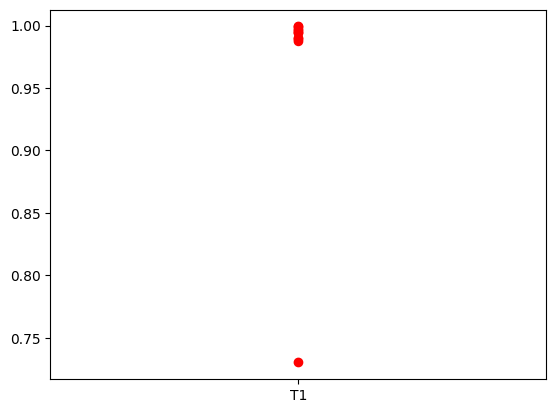

In [127]:
plt.scatter(classifier_x, classifier_y, c=colors)

The second model is one that uses 'text classification' for both, so it determines a sentiment towards both teams based on the input. This in theory should allow for better understanding of multi-intention comments, but in practice the model cannot determine the context for the input, as well as which specifically each phrase/section is intended for. 

In [128]:
sentiment_analysis.head(1)

,comment
0,"{""T1"": {""label"": ""NEUTRAL"", ""score"": 0.0, ""text"": ""Previous T1 vs. Gen.G / 2024 World Championship - Semi-Final / Post-Match Discussion Faker getting caught mid (alternate universe edition) Calm down, its just another classic. Faker for inhi""}, ""Geng"": {""label"": ""NEUTRAL"", ""score"": 0.0, ""text"": ""Previous T1 vs. Gen.G / 2024 World Championship - Semi-Final / Post-Match Discussion Faker getting caught mid (alternate universe edition) Calm down, its just another classic. Faker for inhi""}}"


In [129]:
keys = list(json.loads(sentiment_analysis['comment'].iloc[0]).keys())

sentiment_x = keys * len(sentiment_analysis)
sentiment_y = [
    json.loads(v)[key]['score']
    for v in sentiment_analysis['comment']
    for key in keys
]
colors = [
    'red' if json.loads(v)[key]['label'] == "NEGATIVE" 
    else 'yellow' if json.loads(v)[key]['label'] == "NEUTRAL" 
    else 'blue' 
    for v in sentiment_analysis['comment']
    for key in keys
]

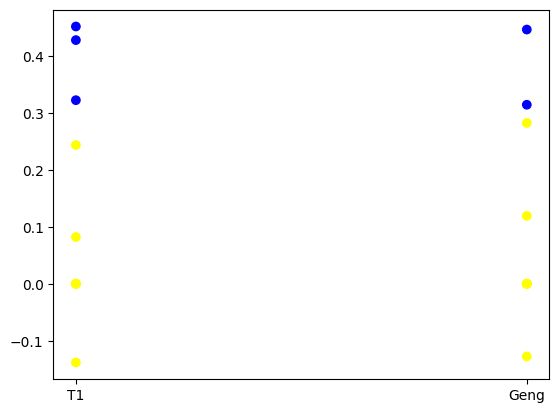

In [130]:
plt.scatter(sentiment_x, sentiment_y, c=colors)

The above are the two outputs for the two sentiment analysis models run. It can be seen that there are wildly different feelings, especially when one model classifies all posts towards specifically one team, as well as all being negative. It seems that current sentiment analysis models don't run very well when comparing the feelings towards two teams. The above are the two ways I believed in theory would work the best, which turned out neither of them really worked. 

My current belief is that neither model can distinguish intent, as in which part of the sentence is related to which keyword. Thus, the model misunderstands which feeling is towards which team, and classifies everything as negative or everything as neutral. As well, a downside is the importance of context, especially in relation towards a thread. This demo looked to see how well a model can interpret the feelings of a certain thread, which meant that context must also be fed into the model. This skews the results both practically, more below, and in theory. The importance of the previous messages do not matter, as those should already have a sentiment placed on them, however models, especially trained specifically towards sentiment analysis, don't currently have a way to distinguish between the two, only really understanding the input as a whole. If there was a way to tweak the model to weigh the later tokens higher, it might provide a better outcome. Especially in this context, where the reddit post itself is included in the thread (the result of the matches), and especially the post itself being quite bulky comparably, due to the nature of comments, it might have skewed the data, especially in the classifier analysis section. 

Finally, technological drawbacks hindered the ability for this model to perform. A lot of the scrapped data was not used (because my computer would probably die - just running it on 10 inputs takes long enough each, it would take wayyyyy to long to run the model on all 3600+ scrapped inputs). As well, the models used are not the strongest (the maximum token input is 128) and so the each input had to be chunked and averaged, also skewing it to a more even weighting compared to a later weighting. The chunking, however, allows weighting for later sections as the value can be adjusted, but chunking as a concept should be avoided if necessary, because the machine loses contextual clues which are especially important. A better (bigger) model would be beneficial, but there still the downside of context that the machine lacks. It might be better using a pure LLM, as the context size would be big enough and the prompt can be tweaked in a way to determine sentiment. 